In [1]:
import matplotlib.pyplot as plt
import torch
import sys
import os
sys.path.append(os.environ["LATENT_PATH"])
import pickle
from auto_localization.experiment_management.basic_experiment import BasicExperiment
from auto_localization.dataset_management.data_manager import DataManager
from datasets.morpho_mnist.dataset import ImageDataset, TripletDataset, MetadataDataset
from auto_localization.oracles.metadata_oracle import MetadataOracle
from auto_localization.oracles.indexed_metadata_oracle import IndexedMetadataOracle
from auto_localization.oracles.indexed_class_oracle import IndexedClassOracle
from auto_localization.oracles.oracle import EnsembleOracle
from datasets.morpho_mnist.measure import measure_image
from auto_localization.models.loss.masked_vae_triplet_loss import MaskedVAETripletLoss
import auto_localization.models.loss.bayesian_triplet_loss as btl
import numpy as np
from tqdm import tqdm
from torch.distributions.normal import Normal
import matplotlib
import seaborn as sns
import scipy.stats
from torch.distributions.normal import Normal
%matplotlib inline

In [2]:
# load a traditional model
run_name = "earnest-flower-497"
# load up the experiment parameters from the given run_name
run_directory = os.path.join(os.environ["LATENT_PATH"], "auto_localization", "logs", run_name)
# load the expeirment config
params_path = run_directory + "/params.pkl"
with open(params_path, "rb") as f:
    experiment_config = pickle.load(f)
# make the experiment
basic_experiment = BasicExperiment(experiment_config=experiment_config, do_setup=False)
basic_experiment.load_data(run_directory)
# get the model
model = basic_experiment.model

wandb: Currently logged in as: helblazer811 (use `wandb login --relogin` to force relogin)


Setting Up Logging


wandb: wandb version 0.12.9 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Setup Model Config
Setting Up Model
IsolatedVAE(
  (loss_function): IsolatedTripletLoss(
    (empty_linear): Linear(in_features=1, out_features=1, bias=True)
    (triplet_margin_loss): TripletMarginLoss()
  )
  (conv1): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv1_bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv2_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv3_bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv4_bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (similarity_mean_linear): Linear(in_features=1024, out_features=10, bias=True)
  (similarity_logvar_l

In [3]:
# setup tripelt dataset
which_digits=[1]
component_weighting = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
one_two_ratio = 0.0
attribute_return = True

metadata_dataset = MetadataDataset(
    train=True, 
    which_digits=which_digits
)
metadata_oracle = IndexedMetadataOracle(
    metadata_dataset=metadata_dataset,
    component_weighting=component_weighting,
)

image_train = ImageDataset(train=True)
image_test = ImageDataset(train=False)

# setup data manager
triplet_train_dataset = TripletDataset(
    train=True,
    which_digits=which_digits,
    oracle=metadata_oracle,
    one_two_ratio=one_two_ratio,
    attribute_return=attribute_return, 
    single_feature_triplet=True
) 
triplet_test_dataset = TripletDataset(
    train=False,
    which_digits=which_digits,
    oracle=metadata_oracle,
    one_two_ratio=one_two_ratio,
    attribute_return=attribute_return, 
    single_feature_triplet=True
) 

## Compute Predicted and True Certainties

In [4]:
def calculate_probability(muA, muP, muN, varA, varP, varN, margin = 0.0):
    muA = muA.unsqueeze(0)
    muP = muP.unsqueeze(0)
    muN = muN.unsqueeze(0)
    varA = varA.unsqueeze(0)
    varP = varP.unsqueeze(0)
    varN = varN.unsqueeze(0)
    
    muA2 = muA**2
    muP2 = muP**2
    muN2 = muN**2
    varP2 = varP**2
    varN2 = varN**2

    mu = torch.sum(muP2 + varP - muN2 - varN - 2*muA*(muP - muN), dim=1)
    T1 = varP2 + 2*muP2 * varP + 2*(varA + muA2)*(varP + muP2) - 2*muA2 * muP2 - 4*muA*muP*varP
    T2 = varN2 + 2*muN2 * varN + 2*(varA + muA2)*(varN + muN2) - 2*muA2 * muN2 - 4*muA*muN*varN
    T3 = 4*muP*muN*varA
    sigma2 = torch.sum(2*T1 + 2*T2 - 2*T3, dim=1)
    sigma = sigma2**0.5

    probs = Normal(loc = mu, scale = sigma + 1e-8).cdf(margin)

    return probs
    
# measure of whether or not a query is satisfied by a model
def triplet_forward(model, triplet):
    anchor, positive, negative, attribute_index = triplet
    anchor_mu, anchor_logvar, anchor_z, _ = model.forward(anchor.cuda())
    positive_mu, positive_logvar, positive_z, _ = model.forward(positive.cuda())
    negative_mu, negative_logvar, negative_z, _ = model.forward(negative.cuda())
    
    return ([anchor_mu, anchor_logvar], [positive_mu, positive_logvar], [negative_mu, negative_logvar], attribute_index)

In [5]:
num_images = 500
image_dataset = image_test
mean_vals = []
logvar_vals = []
for i in range(num_images):
    image = image_dataset[i]
    mean, logvar, _, _ = model.forward(image.cuda())
    mean_vals.append(mean.detach().cpu().numpy())
    logvar_vals.append(logvar.detach().cpu().numpy())
mean_vals = np.array(mean_vals)
data_mean = torch.Tensor(np.mean(mean_vals, axis=0)).cuda()
data_var = torch.Tensor(np.var(mean_vals, axis=0)).cuda()

In [8]:
num_sample = 500
means = []
variances = []
for i in range(num_sample):
    image = image_dataset[i]
    mean, logvar, _, _ = model.forward(image.cuda())
    var = logvar.exp()
    means.append(mean)
    variances.append(var)

In [12]:
# calculate 
triplet_dataset = triplet_test_dataset
num_triplets = 2000
trues, expecteds = [], []
projected_variances = []
for index in tqdm(range(num_triplets)):
    triplet, _ = triplet_dataset[index]
    # embedd the triplet
    triplet_out = triplet_forward(model, triplet)
    anchor, positive, negative, _ = triplet_out
    muA, varA = anchor
    varA = varA.exp()
    muP, varP = positive
    varP = varP.exp()
    muN, varN = negative
    varN = varN.exp()
    # calcualte the true probability
    prob = abs(calculate_probability(muA, muP, muN, varA, varP, varN, margin = 0.0).item() - 0.5)
    # calculate the expected probability
    # muA = torch.zeros_like(muA)
    # varA = torch.ones_like(varA)*5
    muA = data_mean
    varA = data_var
    num_sample = 500
    expected_probs = []
    for i in range(num_sample):
        mean = means[i]
        var = variances[i]
        expected_prob = abs(calculate_probability(mean, muP, muN, var, varP, varN, margin = 0.0).item() - 0.5)
        expected_probs.append(expected_prob)
    expected_prob = np.mean(expected_probs)
    expecteds.append(expected_prob)
    # compute projected variances
    varP = varP.detach().cpu().numpy()
    varN = varN.detach().cpu().numpy()
    muP = muP.detach().cpu().numpy()
    muN = muN.detach().cpu().numpy()
    
    connecting_vector = muP - muN
    # connecting_vector /= np.linalg.norm(connecting_vector)
    b_cov = np.diag(varP)
    b_projected_variance = np.dot(connecting_vector, b_cov).dot(connecting_vector)
    a_cov = np.diag(varN)
    a_projected_variance = np.dot(connecting_vector, a_cov).dot(connecting_vector)
    combined_projected_variance = a_projected_variance + b_projected_variance
    trues.append(prob)
    #expecteds.append(expected_prob)
    projected_variances.append(combined_projected_variance)

100%|██████████| 2000/2000 [15:54<00:00,  2.09it/s]


2000
[[1.         0.54187147]
 [0.54187147 1.        ]]
SpearmanrResult(correlation=0.6280400855580361, pvalue=6.7973503031423915e-220)


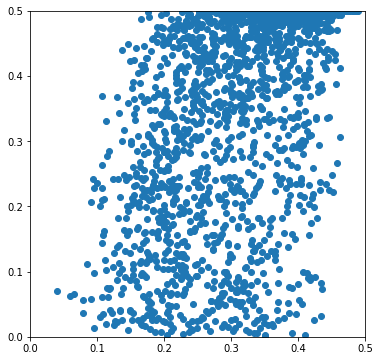

In [13]:
# plot
fig, axs = plt.subplots(figsize=(6, 6))
print(len(expecteds))
plt.scatter(expecteds, trues)
print(np.corrcoef(expecteds, trues))
from scipy import stats
print(stats.spearmanr(expecteds, trues))

plt.ylim(0, 0.5)
plt.xlim(0, 0.5)
plt.show()

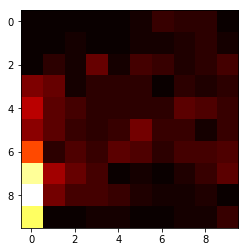

In [11]:
trues = np.array(trues)
H, _, _ = np.histogram2d(expecteds, trues)
H = np.flip(H, axis=1)
plt.imshow(H, cmap='hot', interpolation='nearest')
plt.show()